#Импорты

In [2]:
pip install numpy==1.19.5

     |████████████████████████████████| 14.8 MB 21.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.0+zzzcolab20220506162203 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install pytorch_lightning

     |████████████████████████████████| 584 kB 30.1 MB/s 
     |████████████████████████████████| 409 kB 50.8 MB/s 
     |████████████████████████████████| 140 kB 52.8 MB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
     |████████████████████████████████| 1.1 MB 51.6 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 30.7 MB/s 
     |████████████████████████████████| 144 kB 20.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 22.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [6]:
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [7]:
import pandas as pd #working with data
import seaborn as sns #visualisation

import re

In [8]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, multilabel_confusion_matrix

#Modelling

In [9]:
mental_health = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mental_health_topics.csv')

In [10]:
mental_health.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
mental_health.sample(5)

,topic,full_text
140,suicide,"В моей жизни есть такие замечательные люди, и ..."
2925,positive,Привет всем! Я наконец решилась выполнить зада...
2164,depression,Я неуместный человек. В лучшем случае я просто...
2003,depression,"Дай мне повод продолжать идти, завтра мне испо..."
2367,depression,"Почему я чувствую, что ничего не могу сделать?..."


In [ ]:
mental_health.shape

(3884, 2)

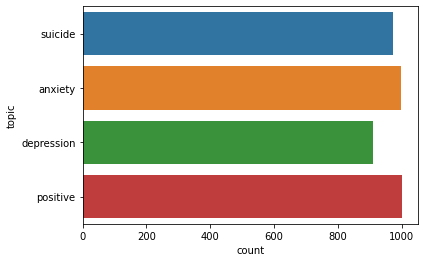

In [ ]:
sns.countplot(y="topic", data=mental_health)

In [ ]:
mental_health['topic'].value_counts()

positive      1000
anxiety        998
suicide        974
depression     912
Name: topic, dtype: int64

In [11]:
explode_df = mental_health.explode('topic')

In [12]:
one_hot=pd.get_dummies(explode_df,columns=['topic'])   
one_hot

,full_text,topic_anxiety,topic_depression,topic_positive,topic_suicide
0,"Новая вики о том, как избежать случайного поощ...",0,0,0,1
1,"Пожалуйста, помните, что НИКАКАЯ АКТИВНОСТЬ зд...",0,0,0,1
2,К черту горячие линии самоубийц и к черту люде...,0,0,0,1
3,"Когда я слышу о людях, которые покончили с соб...",0,0,0,1
4,Надеюсь увидеть вас на другой стороне. Мне оче...,0,0,0,1
...,...,...,...,...,...
3879,"Ёмаё, сходила к психотерапевту!! Доехала одна ...",0,0,1,0
3880,я позвала ее на свидание… я слишком испугалась...,0,0,1,0
3881,"Я просто хочу сказать, что сегодня увидел на в...",0,0,1,0
3882,"ААААА, я так рада!!! Спустя 3 месяца мне након...",0,0,1,0


In [13]:
col_names = one_hot.columns.to_list()
for i in range(len(col_names)):
  col_names[i] = re.sub("topic_","",col_names[i])

In [ ]:
col_names

['full_text', 'anxiety', 'depression', 'positive', 'suicide']

In [ ]:
one_hot.columns = col_names

In [ ]:
one_hot.sample(5)

,full_text,anxiety,depression,positive,suicide
1832,Испытывать беспокойство после многих месяцев ж...,1,0,0,0
3819,"Хочу поделиться не своей победой, а победой че...",0,0,1,0
1216,Мой врач прописал прозак и клоназепам от беспо...,1,0,0,0
2661,"Мне действительно просто нужен компаньон, мне ...",0,1,0,0
596,"Я бы не сказал, что я ”полностью” суицидален. ...",0,0,0,1


In [14]:
one_hot = one_hot.dropna()

In [15]:
train_df, val_df = train_test_split(one_hot, test_size=0.05)
train_df.shape, val_df.shape

((3688, 5), (195, 5))

In [16]:
train_df

,full_text,topic_anxiety,topic_depression,topic_positive,topic_suicide
1921,Последние два дня я очень страдаю от беспокойс...,1,0,0,0
2660,Плакала впервые за несколько месяцев. Мое (22f...,0,1,0,0
1488,Приступ паники в школе Я вернулся в школу впер...,1,0,0,0
3413,"привет! я читала много ваших историй, и решила...",0,0,1,0
269,"Длинная, бессмысленная тирада, Так что странно...",0,0,0,1
...,...,...,...,...,...
3750,"Научилась посылать людей, которые делали/делаю...",0,0,1,0
1468,Только физические симптомы тревоги Недавно у м...,1,0,0,0
1261,Каковы ваши самые страшные / самые раздражающи...,1,0,0,0
1788,"Такое чувство, что все смотрят на меня? Я пыта...",1,0,0,0


In [17]:
BERT_MODEL_NAME = 'DeepPavlov/rubert-base-cased-sentence'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [ ]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["full_text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

In [18]:
LABEL_COLUMNS = one_hot.columns.tolist()[1:]

In [19]:
MAX_TOKEN_COUNT = 512

In [ ]:
class MentalHealthDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.full_text
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = MentalHealthDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["comment_text"]

'Чувство безнадежности и потерянности. Я хожу к психологу уже чуть больше года, и ни одно из лекарств не помогло мне справиться с тревогой. Единственное, что работало в прошлом, - это Ксанакс, но сейчас его так трудно получить из-за клейма. Я также страдаю биполярным расстройством и принимаю Сероквель и Ламиктал в настоящее время, психолог утверждал, что Ламиктал поможет справиться с тревогой, более конкретно с социальной тревогой, но это НЕ ПОМОГАЕТ, и я не могу продолжать так жить. Кто-нибудь знает лекарства, которые помогают от социальной тревожности, но не являются Ксанаксом? Я пробовал Пропанолол, Гидроксизин, Ламиктал. Мои психи опасаются прописывать мне все, что может вызвать привыкание. А еще я лечусь у психотерапевта.'

In [ ]:
class MentalHealthDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = MentalHealthDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = MentalHealthDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 12
data_module = MentalHealthDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [20]:
class MentalHealthTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence', return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask):#, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
    
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(184, 921)

In [ ]:
model = MentalHealthTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

In [ ]:
criterion = nn.BCELoss()

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="mental-health")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f2405238e10>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f2405238e10>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [ ]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs/mental-health
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 177 M 
1 | classifier | Linear    | 3.1 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.426   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test()

In [ ]:
trained_model = MentalHealthTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
test_comment = "я dead inside"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

anxiety: 0.01970321126282215
depression: 0.18054649233818054
positive: 0.10498436540365219
suicide: 0.7196567058563232


In [ ]:
output = model(encoding["input_ids"], encoding["attention_mask"])

In [ ]:
test_comment = 'я люблю гулять'
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
output = model(encoding["input_ids"], encoding["attention_mask"])

In [ ]:
output.shape

torch.Size([1, 4])

In [ ]:
THRESHOLD = 0.5
test_comment = ""
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = MentalHealthDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
THRESHOLD = 0.5

In [ ]:
accuracy(predictions, labels, threshold=0.5)

tensor(0.9244)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
anxiety: 0.9705060124397278
depression: 0.9249999523162842
positive: 1.0
suicide: 0.948976457118988


In [ ]:
import numpy as np

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

              precision    recall  f1-score   support

     anxiety       0.94      0.81      0.87        57
  depression       0.64      0.75      0.69        40
    positive       1.00      1.00      1.00        54
     suicide       0.80      0.80      0.80        44

   micro avg       0.85      0.85      0.85       195
   macro avg       0.84      0.84      0.84       195
weighted avg       0.86      0.85      0.85       195
 samples avg       0.84      0.85      0.84       195



In [ ]:
PATH = 'model_original.pt'

In [ ]:
torch.save(trained_model.state_dict(), PATH)

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
# must be the same size a minibatch with 1 example image
#example = torch.rand(1, 3, 224, 224)

state_dict = torch.load('model_original.pt', map_location='cpu')
model = MentalHealthTagger(n_classes=4)
model.load_state_dict(state_dict)
model.eval()

# move model back to cpu, do tracing, and optimize
#model_conv = trained_model.to("cpu")
traced_script_module = torch.jit.trace(model, [encoding["input_ids"], encoding["attention_mask"]])
torchscript_model_optimized = optimize_for_mobile(traced_script_module)
#traced_script_module.code
# save optimized model for mobile
#PATH = 'model-opt.pt'
#torchscript_model_optimized.save(PATH)
torchscript_model_optimized._save_for_lite_interpreter("model-opt.ptl")

#print(f"optimized model saved to {PATH}")

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: `LightningModule.use_amp` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.amp_backend`.
  if hasattr(mod, name):
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: `LightningModule.use_amp` was deprecated in v1.6 and will be removed in v1.8. Please use `Traine

In [ ]:
traced_script_module.code

'def forward(self,\n    input_ids: Tensor,\n    attention_mask: Tensor) -> Tensor:\n  classifier = self.classifier\n  bert = self.bert\n  _0 = (bert).forward(input_ids, attention_mask, )\n  _1 = torch.sigmoid((classifier).forward(_0, ))\n  return _1\n'